In [211]:
# import modules
import folium 
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import CRS
import folium
from folium.plugins import Search, MarkerCluster

Read datasets

In [212]:
# dataset names
fp_schools = r"D:\Gustavo\resource_center\RLIS\PLACES\schools.shp"
fp_zipcodes = r"D:\Gustavo\resource_center\RLIS\zip_code_boundaries\Zip_Code_Boundaries.shp"

schools = gpd.read_file(fp_schools)
zipcodes = gpd.read_file(fp_zipcodes)

In [213]:
# re-define columns for the GeoDataFrames
schools = schools[['NAME', 'ADDRESS', 'CITY', 'STATE', 'ZIPCODE', 'COUNTY', 'geometry']]
zipcodes = zipcodes[['NAME', 'TYPE','ZIPCODE', 'STATE', 'geometry']]

# Changing UpperCase column names for lowerCase
schools.columns = [x.lower() for x in schools.columns]
zipcodes.columns = [x.lower() for x in zipcodes.columns]
# schools.columns = schools.columns.str.lower() # from UPPERCASE to lowercase

In [214]:
# check the Coordinate Reference System of the gdf
schools.crs
zipcodes.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [215]:
# re-project zipcode geodataframe:
schools=schools.to_crs(4326)
zipcodes=zipcodes.to_crs(4326)

In [216]:
# Create a index column in school, libraries, zipcode, geodataframes
schools['geoid'] = schools.index.astype(str)

In [217]:
## Check that column names were changed to lowercase
# schools.columns
# zipcodes.columns


Let's retrieve `Latitude` and `Longitude` from the geometry column in schools

In [218]:
schools['lon']= schools.geometry.x # Add lon column to geodataframe
schools['lat']= schools.geometry.y # Add lon column to geodataframe

In [219]:
# Check that the columns were created
schools.head()

,name,address,city,state,zipcode,county,geometry,geoid,lon,lat
0,River Grove Elementary,5850 MCEWAN RD,LAKE OSWEGO,OR,97035,Clackamas,POINT (-122.73640 45.38916),0,-122.736396,45.389161
1,Firwood Elementary,42900 SE TRUBEL RD,SANDY,OR,97055,Clackamas,POINT (-122.22171 45.37377),1,-122.221715,45.373775
2,Dundee Elementary,140 SW 5TH ST,DUNDEE,OR,97115,Yamhill,POINT (-123.01052 45.28069),2,-123.010523,45.280689
3,Fern Hill Elementary,4445 HEATHER ST,FOREST GROVE,OR,97116,Washington,POINT (-123.07219 45.51456),3,-123.072188,45.514557
4,Mt. Hood Community College,26000 SE STARK ST,GRESHAM,OR,97030,Multnomah,POINT (-122.39626 45.51573),4,-122.396258,45.515729


__Crate a pandas series that will contain the number of schools per zipcode__

In [220]:
# create pandas series with zipcodes count from schools gdf
zlist = schools['zipcode'].value_counts()

# Create a new dataframe from pandas series zlist
zipcodes_list = zlist.to_frame(name='count')

zipcodes_list.columns

Index(['count'], dtype='object')

In [221]:
# reset index
zipcodes_list= zipcodes_list.reset_index()

# rename columns
zipcodes_list = zipcodes_list.rename(columns={'index':'zipcode'})

# add geoid column to zipcodes_list
zipcodes_list['geoid'] = zipcodes_list.index.astype(str)

#re-distribute columns
zipcodes_list = zipcodes_list[['geoid', 'zipcode', 'count']]

In [222]:
# check dataframe zipcodes_list
zipcodes_list

,geoid,zipcode,count
0,0,97045,42
1,1,97006,35
2,2,97219,29
3,3,97124,28
4,4,97030,26
...,...,...,...
78,78,97004,1
79,79,97078,1
80,80,97109,1
81,81,97032,1


Merge zipcodes_list and zipcodes dataframes using zipcode column as key

In [223]:
sch_zip_list = list(zipcodes_list['zipcode'])

In [224]:
zipcodes.loc[zipcodes['zipcode'].isin(sch_zip_list)]

,name,type,zipcode,state,geometry
0,NEWBERG,STANDARD ZIPCODE,97132,OR,"POLYGON ((-122.94407 45.39454, -122.94302 45.3..."
1,TIGARD,STANDARD ZIPCODE,97224,OR,"POLYGON ((-122.83191 45.42202, -122.82779 45.4..."
6,CORNELIUS,STANDARD ZIPCODE,97113,OR,"POLYGON ((-122.99132 45.45043, -122.99129 45.4..."
7,GASTON,STANDARD ZIPCODE,97119,OR,"POLYGON ((-123.05768 45.41389, -123.05748 45.4..."
8,PORTLAND,STANDARD ZIPCODE,97266,OR,"POLYGON ((-122.54925 45.50912, -122.54926 45.5..."
...,...,...,...,...,...
113,ESTACADA,STANDARD ZIPCODE,97023,OR,"POLYGON ((-122.22698 45.30903, -122.22445 45.3..."
114,HAPPY VALLEY,STANDARD ZIPCODE,97086,OR,"POLYGON ((-122.49399 45.42935, -122.49398 45.4..."
115,MARYLHURST,STANDARD ZIPCODE,97036,OR,"POLYGON ((-122.64474 45.40001, -122.64385 45.3..."
116,GOVERNMENT CAMP,STANDARD ZIPCODE,97028,OR,"POLYGON ((-121.68677 45.28020, -121.68685 45.2..."


In [225]:
zipcodes = zipcodes.merge(zipcodes_list, on='zipcode')

In [226]:
zipcodes.sort_values(by='zipcode', ascending=True).head()

,name,type,zipcode,state,geometry,geoid,count
46,BEAVERCREEK,STANDARD ZIPCODE,97004,OR,"MULTIPOLYGON (((-122.37336 45.23252, -122.3733...",78,1
68,BEAVERTON,STANDARD ZIPCODE,97005,OR,"POLYGON ((-122.82714 45.48494, -122.82707 45.4...",25,16
49,BEAVERTON,STANDARD ZIPCODE,97006,OR,"POLYGON ((-122.89970 45.52712, -122.89933 45.5...",1,35
57,BEAVERTON,STANDARD ZIPCODE,97007,OR,"POLYGON ((-122.93322 45.44719, -122.93354 45.4...",11,23
22,BEAVERTON,STANDARD ZIPCODE,97008,OR,"POLYGON ((-122.77638 45.47294, -122.77596 45.4...",27,14


__Save the Geodataframe as shapefile__

In [257]:
output=r"C:\Users\gcolm\Documents\courses\online\online_courses\others\Geo_python_course\autoGIS_2019\lesson_5\data\pnw_schoolsPerZipcodes.shp"

zipcodes.to_file(output)

In [228]:
# Let's check the distribution of schools per zipcode ; Min and Max
zipcodes.describe()

,count
count,79.000000
mean,12.215190
std,8.808025
min,1.000000
25%,5.000000
50%,12.000000
75%,17.500000
max,42.000000


ColorScale: <br>
* Define min and max values from count column

In [229]:
min_, max_ = zipcodes['count'].quantile([0.05, 1])

# Define mean value
mean = zipcodes['count'].mean()

# Print the min, max, and mean values
print(f'Min: {min_}\nMax: {max_}\nMean: {mean}')

Min: 1.0
Max: 42.0
Mean: 12.215189873417721


Let's make a color scale.<br>
For this case we are going to use a colorscale with a sequential light-to-dark color palette from [ColorBrewer](https://colorbrewer2.org/#type=sequential&scheme=Purples&n=5) website
Another great resource is [Folium ColorMap samples](https://notebook.community/ocefpaf/folium/examples/Colormaps)

In [244]:
import branca

# Define color pallet
# color_pallet= []

# Find source and samples in https://notebook.community/ocefpaf/folium/examples/Colormaps
# syntax : branca.colormap.linear.<colorscale>_<#classes>.scale(min_value, max_value)
colormap = branca.colormap.linear.YlGnBu_05.scale(min_, max_) 

# color bar title
colormap.caption= 'Number of Schools per zipcode'

colormap

__Time to buil the Map__<br>
Let's start by clustering all the points

In [231]:
# Create dataframe series from the lat and lon columns
lat= schools['lat']
lon= schools['lon']

# Create dataframe series from name, city, state, zipcode colunns
name= schools['name']
city= schools['city']
state= schools['state']
zipcode= schools['zipcode']

locations = list(zip(lat, lon)) # list of the lat and lon from the schools gdf

naming= list(zip(name, city, state, zipcode)) # list of all name, city, state, zipcode

popups= [f'Name: {name}<br>City: {city}<br>State: {state}<br>Zipcode: {zipcode}' for (name, city, state, zipcode) in naming]

In [232]:
locations

[(45.38916139091954, -122.73639609393878),
 (45.37377460835237, -122.22171473821277),
 (45.28068926567289, -123.01052327323015),
 (45.51455738294126, -123.0721878695466),
 (45.51572887462792, -122.39625754564953),
 (45.51989724227386, -122.41036928095899),
 (45.34311460201515, -123.18584339073325),
 (45.58597155020716, -123.21559711467071),
 (45.538802898420855, -122.83593463286107),
 (45.51536559838526, -122.94180801843262),
 (45.50443392399512, -122.91519520459318),
 (45.49014423286476, -123.12760971142417),
 (45.48476344129025, -122.86871573824271),
 (45.46882088411306, -122.81873448196431),
 (45.445631749752835, -122.77097482255394),
 (45.403260265718124, -122.76819415490355),
 (45.511861862452044, -122.9211457229619),
 (45.65562634413148, -122.82557957962382),
 (45.57269231681542, -122.72751471894937),
 (45.55816737503957, -122.65912815894248),
 (45.54886384136376, -122.62080827807755),
 (45.54159481315648, -122.4886264275574),
 (45.52835706779681, -122.47226130402957),
 (45.52104

### Create a Static Map

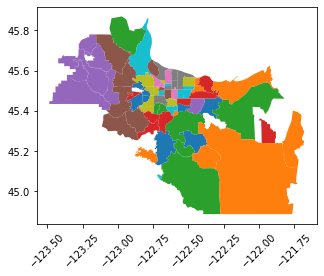

In [233]:
zipcodes.plot(column='zipcode')
plt.xticks(rotation=45)
plt.show()

## Create an Interactive Map
__Create style function with a classification scheme__

In [249]:
%%time

# Create map instance
m = folium.Map(location=[np.mean(lat), np.mean(lon)]
               ,width="100%", height="100%"
               ,zoom_start=10, min_zoom=9, max_zoom=19
               ,tiles="cartodbpositron"
               ,control_scale=True)


# define style
style_function=lambda x: {
    'fillColor': colormap(x['properties']['count'])
    ,'color':'white'
    ,'weight': 2
    ,'fillOpacity': 0.5
}

# Add Population layer to m
count_geo= folium.GeoJson(
    zipcodes
    ,name='Zipcodes'
    ,style_function=style_function
    ,tooltip=folium.GeoJsonTooltip(
        fields=['zipcode', 'count']
        ,aliases=['zipcode: ','Count: ']
        ,localize=True
    )
).add_to(m)


# # # # ======================================== # # # #  
# Add marker cluster layer for the schools
marker_cluster = MarkerCluster()
marker_cluster = folium.plugins.FastMarkerCluster(locations)


marker_cluster = MarkerCluster(
    locations= locations, popups= popups,
    name = 'Schools',
    overlay= True,
    control= True
)

# Add marker cluster
marker_cluster.add_to(m)

# Add layer control
colormap.add_to(m)
folium.LayerControl().add_to(m)

Wall time: 818 ms


In [258]:
# save the map
output =r"C:\Users\gcolm\Documents\courses\online\online_courses\others\Geo_python_course\autoGIS_2019\lesson_5\docs\PNW_schoolsPerZipcode.html"
 
m.save(output)
# Display the interactive map
m